<a href="https://colab.research.google.com/github/tchintchie/whgscraper/blob/master/soup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [205]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                return None

    except RequestException as e:
        log_error(f'Error during requests to {url} : {str(e)}')
        return None

In [206]:

def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)

In [207]:

def log_error(e):
    """
    It is always a good idea to log errors. 
    This function just prints them, but you can
    make it do anything.
    """
    print(e)

In [208]:
url = "https://www.oehboersen.at"
html = simple_get(url)

In [209]:
oeh = bs(html, "html5lib")

In [210]:
title = oeh.title.string

In [211]:
rows = oeh.find_all("div", class_="property-content")
rows[0]

<div class="property-content">
		
				<div class="row visible-xs visible-sm">
			<span class="type">Sonstiges</span> <span>·</span> <span class="status">Miete</span>		</div>
		
		<div class="row headlines">
			<a href="https://www.oehboersen.at/property/modernes-reihenhaus-in-schoener-und-zentraler-lage-in-unmittelbarer-naehe-der-bushaltestelle-in-mils-bei-hall-mit-wunderschoenem-ausblick-ab-september-zu-vermieten/" tabindex="0"><h3 class="title col-sm-8">Modernes Reihenhaus in schöner und zentraler Lage in un  <i class="fa fa-ellipsis-h" data-original-title="Modernes Reihenhaus in schöner und zentraler Lage in unmittelbarer Nähe der Bushaltestelle in Mils bei Hall mit wunderschönem Ausblick ab September zu vermieten." data-placement="bottom" data-toggle="tooltip" title="Modernes Reihenhaus in schöner und zentraler Lage in unmittelbarer Nähe der Bushaltestelle in Mils bei Hall mit wunderschönem Ausblick ab September zu vermieten."></i></h3> </a>
			<div class="price-tag col-sm-4"><h4 c

In [212]:
p = oeh.find("ul",class_="page-numbers")
end = int([li.text for li in p("li")][-2])

In [213]:
def scrape_pages():

  titles = []
  types = []
  prices = []
  bks = []
  areas = []
  
  for i in range(1,end+1):
    url = "https://www.oehboersen.at/page/0"
    html = simple_get(url)
    oeh = bs(html, "html.parser")
    for div in oeh.find_all("div",class_ = "property-content"):
      title = div.find("h3",class_="title col-sm-8").text
      titles.append(title)
      type_ = div.find("span", class_="type").text
      types.append(type_)
      price=div.find("h4",class_= "price text-primary").next
      prices.append(price)
      bk= div.find("span", class_="BKInfo").text
      bks.append(bk)
      if div.find("div", attrs={"title":"Fläche des Mietgegenstandes"}) != None:
        area = div.find("div", attrs={"title":"Fläche des Mietgegenstandes"}).text
      else:
        area = "NA"
      areas.append(area)
    titles_s = pd.Series(titles, name="title")
    types_s = pd.Series(types, name = "type")
    prices_s = pd.Series(prices, name="price")
    bks_s = pd.Series(bks, name = "bk")
    areas_s = pd.Series(areas, name = "area")  
  return pd.concat([titles_s, types_s, prices_s, bks_s, areas_s], axis = 1)

In [214]:
all_content = scrape_pages()

In [215]:
all_content

,title,type,price,bk,area
0,Modernes Reihenhaus in schöner und zentraler L...,Sonstiges,"€ 1700,-",(inkl. BK),NA
1,"Ich biete Privatzimmer mit Balkon, Dusche, Toi...",Zimmer in 3er WG,"€ 400,-",(inkl. BK),26 m2
2,"Garagenstellplatz, Amraser Straße, Sonnpark, N...",Autoabstellplatz,"€ 95,-",(inkl. BK),NA
3,Zimmer in 3er WG am Innrain,Zimmer in 3er WG,"€ 390,-",(inkl. BK),20 m2
4,"Garconniere 25m2 €590.- inkl. BK, Heizung, Strom",Garçonnière,"€ 590,-",(inkl. BK),25 m2
...,...,...,...,...,...
247,Über den Dächern von Innsbruck,Zimmer in 3er WG,"€ 450,-",(inkl. BK),20 m2
248,2-Zimmer-Wohnung mit separater Küche und 2 Bal...,2-Zimmer Wohnung,"€ 820,-",(inkl. BK),56 m2
249,Schöne 2-Zi-Wohnung mit 2 Balkonen,2-Zimmer Wohnung,"€ 850,-",(inkl. BK),50 m2
250,Vermiete Kleinwohnung in Innsbruck Uni-/Klinik...,Garçonnière,"€ 500,-",(inkl. BK),NA


In [216]:
all_content["type"].value_counts()

Zimmer in 3er WG    84
Garçonnière         48
2-Zimmer Wohnung    36
4-Zimmer Wohnung    24
Autoabstellplatz    24
Zimmer in WG        12
Zimmer in 2er WG    12
Sonstiges           12
Name: type, dtype: int64

In [217]:
all_content.bk.value_counts()

(inkl. BK)    252
Name: bk, dtype: int64

In [218]:
all_content["price"] = all_content.price.str.replace("€","").str.strip().str.replace(",-","").str.replace(",",".").str.strip().astype("float")

In [219]:
all_content["area"] = all_content.area.str.replace("m2","").str.replace("NA", "0").str.strip().astype("float")

In [220]:
all_content["type"] = all_content["type"].astype("category")

In [221]:
all_content["type"].cat.categories

Index(['2-Zimmer Wohnung', '4-Zimmer Wohnung', 'Autoabstellplatz',
       'Garçonnière', 'Sonstiges', 'Zimmer in 2er WG', 'Zimmer in 3er WG',
       'Zimmer in WG'],
      dtype='object')

In [222]:
no_wg = all_content.copy()
no_wg["type"] = no_wg["type"].cat.remove_categories(['Autoabstellplatz','Zimmer in 2er WG', 'Zimmer in 3er WG', 'Zimmer in WG', "Sonstiges"])
no_wg.head()

,title,type,price,bk,area
0,Modernes Reihenhaus in schöner und zentraler L...,NaN,1700.0,(inkl. BK),0.0
1,"Ich biete Privatzimmer mit Balkon, Dusche, Toi...",NaN,400.0,(inkl. BK),26.0
2,"Garagenstellplatz, Amraser Straße, Sonnpark, N...",NaN,95.0,(inkl. BK),0.0
3,Zimmer in 3er WG am Innrain,NaN,390.0,(inkl. BK),20.0
4,"Garconniere 25m2 €590.- inkl. BK, Heizung, Strom",Garçonnière,590.0,(inkl. BK),25.0


In [223]:
dups = no_wg[no_wg.duplicated()].copy()
dups

,title,type,price,bk,area
21,Modernes Reihenhaus in schöner und zentraler L...,NaN,1700.0,(inkl. BK),0.0
22,"Ich biete Privatzimmer mit Balkon, Dusche, Toi...",NaN,400.0,(inkl. BK),26.0
23,"Garagenstellplatz, Amraser Straße, Sonnpark, N...",NaN,95.0,(inkl. BK),0.0
24,Zimmer in 3er WG am Innrain,NaN,390.0,(inkl. BK),20.0
25,"Garconniere 25m2 €590.- inkl. BK, Heizung, Strom",Garçonnière,590.0,(inkl. BK),25.0
...,...,...,...,...,...
247,Über den Dächern von Innsbruck,NaN,450.0,(inkl. BK),20.0
248,2-Zimmer-Wohnung mit separater Küche und 2 Bal...,2-Zimmer Wohnung,820.0,(inkl. BK),56.0
249,Schöne 2-Zi-Wohnung mit 2 Balkonen,2-Zimmer Wohnung,850.0,(inkl. BK),50.0
250,Vermiete Kleinwohnung in Innsbruck Uni-/Klinik...,Garçonnière,500.0,(inkl. BK),0.0


In [224]:
no_wg = no_wg[~no_wg.duplicated()].copy()
no_wg

,title,type,price,bk,area
0,Modernes Reihenhaus in schöner und zentraler L...,NaN,1700.0,(inkl. BK),0.0
1,"Ich biete Privatzimmer mit Balkon, Dusche, Toi...",NaN,400.0,(inkl. BK),26.0
2,"Garagenstellplatz, Amraser Straße, Sonnpark, N...",NaN,95.0,(inkl. BK),0.0
3,Zimmer in 3er WG am Innrain,NaN,390.0,(inkl. BK),20.0
4,"Garconniere 25m2 €590.- inkl. BK, Heizung, Strom",Garçonnière,590.0,(inkl. BK),25.0
5,TG Abstellplatz,NaN,115.0,(inkl. BK),0.0
6,"Neuwertige sehr gut aufgeteilte, WG geeignete,...",2-Zimmer Wohnung,835.0,(inkl. BK),45.0
7,Helles Zimmer mit Balkon,NaN,460.0,(inkl. BK),0.0
8,Schönes Zimmer in 2 er WG am Mentlberg,NaN,470.0,(inkl. BK),45.0
9,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0


In [225]:
no_wg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21 entries, 0 to 20
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   21 non-null     object  
 1   type    9 non-null      category
 2   price   21 non-null     float64 
 3   bk      21 non-null     object  
 4   area    21 non-null     float64 
dtypes: category(1), float64(2), object(2)
memory usage: 965.0+ bytes


In [226]:
no_wg.dropna(axis = 0, inplace=True)

In [227]:
no_wg.reset_index(inplace=True,drop = True)

In [228]:
no_wg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   title   9 non-null      object  
 1   type    9 non-null      category
 2   price   9 non-null      float64 
 3   bk      9 non-null      object  
 4   area    9 non-null      float64 
dtypes: category(1), float64(2), object(2)
memory usage: 529.0+ bytes


In [229]:
# Miete je m2
no_wg["price_per_m2"] = no_wg.price/no_wg.area
no_wg.head()

,title,type,price,bk,area,price_per_m2
0,"Garconniere 25m2 €590.- inkl. BK, Heizung, Strom",Garçonnière,590.0,(inkl. BK),25.0,23.600000
1,"Neuwertige sehr gut aufgeteilte, WG geeignete,...",2-Zimmer Wohnung,835.0,(inkl. BK),45.0,18.555556
2,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0,10.526316
3,"Großgarçonnière, Tivolinähe",Garçonnière,750.0,(inkl. BK),50.0,15.000000
4,4 ZIMMERWOHNUNG IN HÖTTINGER AU ALS 3ER WG AN ...,4-Zimmer Wohnung,1800.0,(inkl. BK),100.0,18.000000


In [230]:
no_wg.describe()

,price,area,price_per_m2
count,9.000000,9.000000,9.000000
mean,859.444444,50.111111,inf
std,386.170659,31.841186,NaN
min,500.000000,0.000000,10.526316
25%,590.000000,30.000000,15.000000
50%,820.000000,50.000000,18.000000
75%,850.000000,56.000000,19.666667
max,1800.000000,100.000000,inf


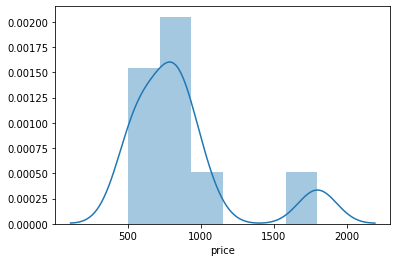

In [231]:
sns.distplot(no_wg.price)
plt.show()

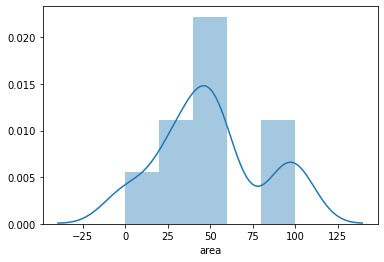

In [232]:
sns.distplot(no_wg.area)
plt.show()

In [233]:
# Miete je Whg-Type
groups = no_wg.groupby(by="type").mean()

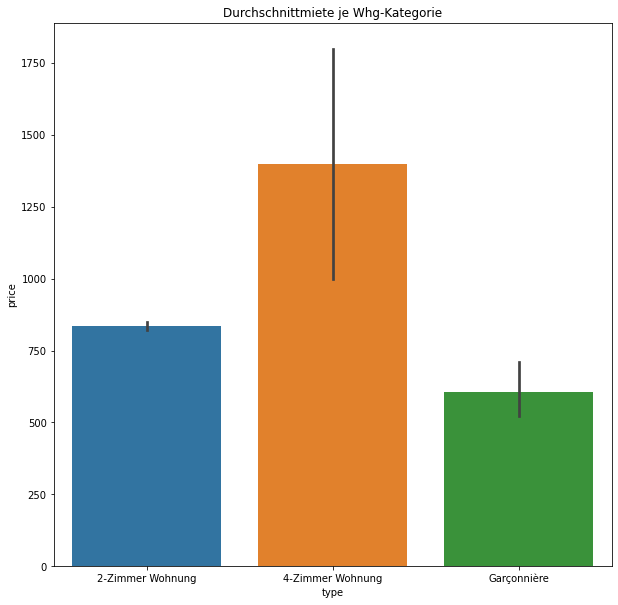

In [234]:
fig = plt.figure(figsize = (10,10))
sns.barplot(x = no_wg["type"], y = no_wg.price).set_title("Durchschnittmiete je Whg-Kategorie")
plt.show()

In [235]:
groups

,price,area,price_per_m2
type,,,
2-Zimmer Wohnung,835.0,50.333333,16.732804
4-Zimmer Wohnung,1400.0,97.500000,14.263158
Garçonnière,607.5,26.250000,inf


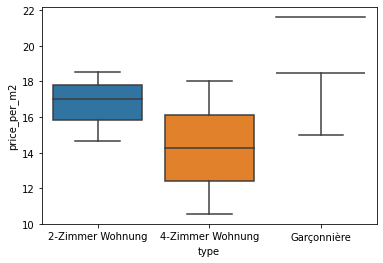

In [236]:
sns.boxplot(x = "type", y = "price_per_m2",  data = no_wg)
plt.show()

In [237]:
top5_cheapest = no_wg.sort_values(by = "price_per_m2").head().copy()
top5_cheapest

,title,type,price,bk,area,price_per_m2
2,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0,10.526316
6,2-Zimmer-Wohnung mit separater Küche und 2 Bal...,2-Zimmer Wohnung,820.0,(inkl. BK),56.0,14.642857
3,"Großgarçonnière, Tivolinähe",Garçonnière,750.0,(inkl. BK),50.0,15.000000
7,Schöne 2-Zi-Wohnung mit 2 Balkonen,2-Zimmer Wohnung,850.0,(inkl. BK),50.0,17.000000
4,4 ZIMMERWOHNUNG IN HÖTTINGER AU ALS 3ER WG AN ...,4-Zimmer Wohnung,1800.0,(inkl. BK),100.0,18.000000


In [238]:
no_inf = no_wg[~no_wg.isin([np.nan, np.inf, -np.inf]).any(1)].copy()

In [239]:
top5_expensive = no_inf.sort_values(by="price_per_m2", ascending=False).head()
top5_expensive

,title,type,price,bk,area,price_per_m2
0,"Garconniere 25m2 €590.- inkl. BK, Heizung, Strom",Garçonnière,590.0,(inkl. BK),25.0,23.600000
5,Zentrale Garconniere mit Balkon,Garçonnière,590.0,(inkl. BK),30.0,19.666667
1,"Neuwertige sehr gut aufgeteilte, WG geeignete,...",2-Zimmer Wohnung,835.0,(inkl. BK),45.0,18.555556
4,4 ZIMMERWOHNUNG IN HÖTTINGER AU ALS 3ER WG AN ...,4-Zimmer Wohnung,1800.0,(inkl. BK),100.0,18.000000
7,Schöne 2-Zi-Wohnung mit 2 Balkonen,2-Zimmer Wohnung,850.0,(inkl. BK),50.0,17.000000


In [240]:
dups.sort_values(by = "title")

,title,type,price,bk,area
51,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0
198,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0
114,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0
93,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0
177,2 Personen für WG gesucht / helle Dachgeschoss...,4-Zimmer Wohnung,1000.0,(inkl. BK),95.0
...,...,...,...,...,...
37,Über den Dächern von Innsbruck,NaN,450.0,(inkl. BK),20.0
247,Über den Dächern von Innsbruck,NaN,450.0,(inkl. BK),20.0
205,Über den Dächern von Innsbruck,NaN,450.0,(inkl. BK),20.0
226,Über den Dächern von Innsbruck,NaN,450.0,(inkl. BK),20.0
